In [286]:
from lcapy import L,C,R
import lcapy
import sympy as sp
import numpy as np
from scipy.constants import e,pi,h
from sympy.core.mul import Mul,Pow,Add
from copy import deepcopy
import matplotlib.pyplot as plt
import math

Note:
 - why use Y and not node matrix? -> because we also want dissipation rates
 - 

In [287]:
def roots(poly_coeffs):
    # Avoids 1e-85 appearing as a coefficient in the polynomial
    order = len(poly_coeffs)-1
    temp = []
    for i in range(order):
        if poly_coeffs[i]!=0.:
            temp.append(np.power(np.abs(poly_coeffs[i]),1./float(order-i)))
    scaling = np.exp(np.average(np.log(temp)))
    poly_coeffs = [p/scaling**(order-i) for i,p in enumerate(poly_coeffs)]
    return np.roots(poly_coeffs)/scaling

# print np.roots([4.200000000000001e-56j, 8.477000000000001e-43, -9.350000000000001e-35j, -1.88e-21, 5e-14j, 1])
# print roots([4.200000000000001e-56j, 8.477000000000001e-43, -9.350000000000001e-35j, -1.88e-21, 5e-14j, 1])

In [288]:
def admittance(circuit):
    if type(circuit) == lcapy.oneport.Par:
        return Add(admittance(circuit.args[0]),admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.Ser:
        return 1/Add(1/admittance(circuit.args[0]),1/admittance(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.L:
        return -sp.I*Mul(1/sp.Symbol('w'),1/sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.C:
        return sp.I*Mul(sp.Symbol('w'),sp.Symbol(circuit.args[0],real=True))
    elif type(circuit) == lcapy.oneport.R:
        return 1/sp.Symbol(circuit.args[0],real=True)

class Bbox(object):
    def __init__(self, circuit, L_J = "L_J"):
        self.circuit = circuit.simplify()
        self.L_J = L_J
        
        Y = admittance(self.circuit)
        self.all_circuit_elements = [str(x) for x in list(Y.free_symbols)]
        self.all_circuit_elements.remove('w')

        Y_numer = sp.numer(sp.together(Y))
        Y_poly = sp.collect(sp.expand(Y_numer),sp.Symbol('w'))
        self.Y_poly = Y_poly
        Y_poly_order = sp.polys.polytools.degree(Y_poly,gen = sp.Symbol('w'))
        Y_poly_coeffs = [Y_poly.coeff(sp.Symbol('w'),n) for n in range(Y_poly_order+1)[::-1]]
        self.Y_poly_num = sp.utilities.lambdify([elt for elt in self.all_circuit_elements],Y_poly_coeffs,"numpy")
        self.N_modes = int(math.ceil((Y_poly_order)/2))
        self.dY = sp.diff(Y,sp.Symbol('w'))
        self.dY_num = sp.utilities.lambdify([elt for elt in self.all_circuit_elements+["w"]],self.dY,"numpy")
    
    def draw(self):
        self.circuit.draw()
        
    def analytical_solution(self):
        # Prints very ugly expressions, need to massage the sympy
        facts = [sp.Q.positive(sp.Symbol(x)) for x in self.all_circuit_elements]
        with sp.assuming(*facts):
        
            # Try and calculate analytical eigenfrequencies
            w_analytical = sp.solve(self.Y_poly,sp.Symbol('w'))

            # Check the number of solutions
            if len(w_analytical)==0:
                print "No analytical solutions"
                return None

            # Compute anharmonicities
            ws = []
            ks = []
            As = []
            for w in w_analytical:
                w_num = complex(w.evalf(subs={i:1. for i in w.free_symbols}))
                if np.real(w_num)>0:
                    ws.append(sp.functions.im(w))
                    ks.append(-sp.functions.re(w))
                    As.append(2.*e**2/h*Mul(1/sp.Symbol(self.L_J),\
                            Mul(Pow(1/sp.functions.im(self.dY.subs({sp.Symbol('w'):sp.functions.im(w)})),2),\
                            Pow(1/sp.functions.im(w),2))))
            return ws,ks,As
    
    def fkA(self,circuit_parameters):
        args = [circuit_parameters[key] for key in self.all_circuit_elements]
        ws_cpx = np.roots(self.Y_poly_num(*args))
        positive_sols = np.argwhere((np.real(ws_cpx)>=0.)&(np.imag(ws_cpx)>=0.))
        ws_cpx=ws_cpx[positive_sols][:,0]
        while True:
            if len(ws_cpx)<self.N_modes:
                ws_cpx=np.concatenate((ws_cpx,[0.]))
            else:
                break
        
        ws = np.real(ws_cpx)
        increasing_frequencies = np.argsort(ws)
        ws = ws[increasing_frequencies]
        ks = np.imag(ws_cpx)[increasing_frequencies]
        
        
        args.append(ws)
        ImdY = np.imag(self.dY_num(*args))
        As = 2.*e**2/h/circuit_parameters[self.L_J]/ws**2/ImdY**2
        return np.concatenate(([ws/2./pi],[ks/2./pi],[As]))
    
    def normalmodes(self,circuit_parameters):
        N_lists = 0
        for key in circuit_parameters:
            if type(circuit_parameters[key]) == np.ndarray or type(circuit_parameters[key])== list:
                N_lists +=1
                key_list = key
        
        if N_lists == 0:
            return self.fkA(circuit_parameters)
        elif N_lists == 1:
            to_iterate = deepcopy(circuit_parameters[key_list])
            circuit_parameters[key_list] = to_iterate[0]
            ret = np.array([self.fkA(circuit_parameters)])
            for key_value in to_iterate[1:]:
                circuit_parameters[key_list] = key_value
                ret = np.concatenate((ret,[self.fkA(circuit_parameters)]),axis = 0)
            return np.transpose(ret,(2,1,0))
        else:
            "Can only iterate on one variable"


In [289]:
b_cQED = Bbox(L('L_J') | C('C') | (C('Cc')+(C('Cr')|L('Lr')|(C('Cf')+R('R_50')))))

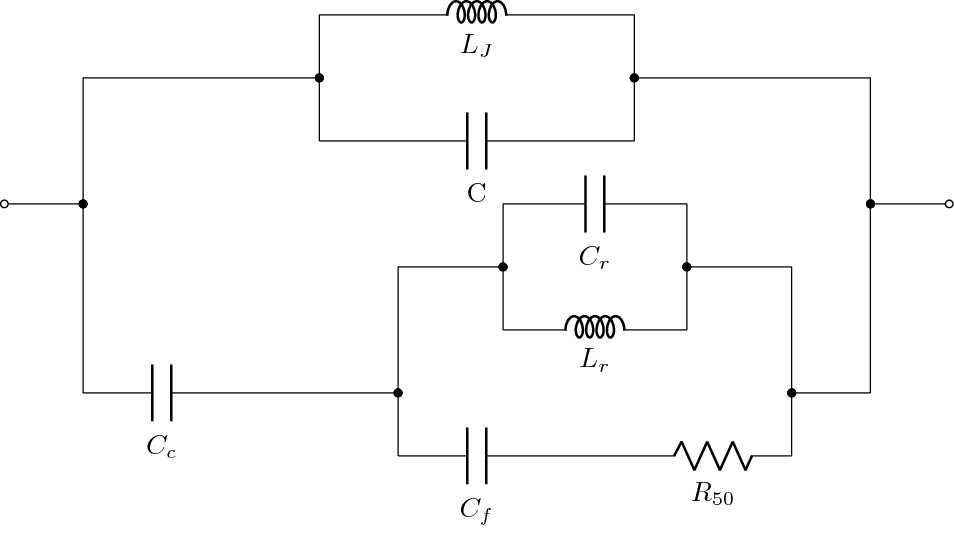

In [275]:
b_cQED.draw()

In [290]:
flux = np.linspace(0.,0.49,103)
L_J_list = 7e-9/abs(np.cos(pi*flux))
to_plot =  np.array(b_cQED.normalmodes({
    'L_J':L_J_list,
    'C':100e-15,
    'Cc':10e-15,
    'Cf':1e-15,
    'R_50':50.,
    'Lr':10e-9,
    'Cr':100e-15,
    'R_J':1e6,
    'R_r':1e5
}))

C:\Anaconda2\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Anaconda2\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Anaconda2\lib\site-packages\ipykernel\__main__.py:79: RuntimeWarning: divide by zero encountered in divide


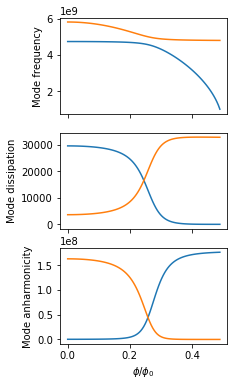

In [291]:
fig,axarr = plt.subplots(3,1,figsize=(3,6),sharex=True)
for i,ax in enumerate(axarr):
    for j in [1,2]:
#     for j in range(b_cQED.N_modes):
        axarr[i].plot(flux,to_plot[j,i])
axarr[0].set_ylabel("Mode frequency")
axarr[1].set_ylabel("Mode dissipation")
axarr[2].set_ylabel("Mode anharmonicity")
axarr[2].set_xlabel("$\phi/\phi_0$")
plt.show()

In [351]:
cir = L('L_J') | (C('C')+C('C_1')) | (C('Cc')+(C('Cr')|L('Lr')|(C('Cf')+R('R_50'))))

In [352]:
def remove_resistances(circuit):
    if type(circuit) == lcapy.oneport.L:
        return circuit
    elif type(circuit) == lcapy.oneport.C:
        return circuit
    elif type(circuit.args[0])==lcapy.oneport.R:
        return circuit.args[1]
    elif type(circuit.args[1])==lcapy.oneport.R:
        return circuit.args[0]
    elif type(circuit) == lcapy.oneport.Par:
        return lcapy.Par(remove_resistances(circuit.args[0]),remove_resistances(circuit.args[1]))
    elif type(circuit) == lcapy.oneport.Ser:
        return lcapy.Ser(remove_resistances(circuit.args[0]),remove_resistances(circuit.args[1]))

In [353]:
cir_no_resistance = remove_resistances(cir).simplify()

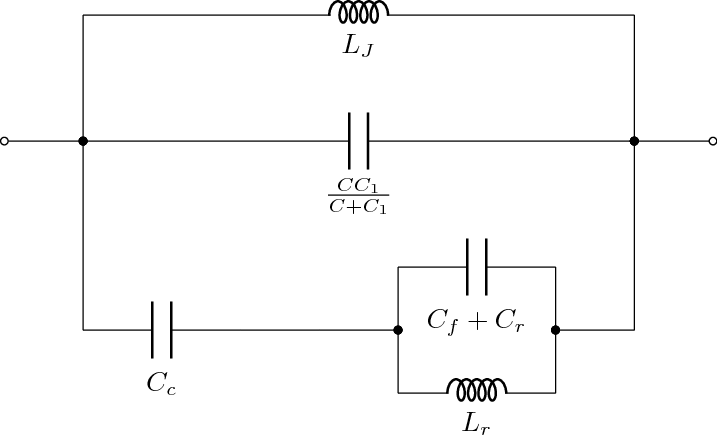

In [354]:
cir_no_resistance.draw()

In [358]:
print cir_no_resistance.netlist()

C 2 3 {C*C_1/(C + C_1)} 0; right
W 1 2; right=0.5
W 2 4; up=0.8
W 3 5; up=0.8
L 4 5 L_J; right
W 2 6; down=1.2
W 3 7; down=1.2
C 6 8 Cc; right
W 8 9; right=0.5
W 9 10; right=0.5
W 10 12; up=0.4
W 11 13; up=0.4
C 12 13 {C_f + C_r} 0; right
W 10 14; down=0.4
W 11 15; down=0.4
L 14 15 Lr; right
W 11 7; right=0.5
W 3 0; right=0.5


In [357]:
wires = []
for line in cir_no_resistance.netlist().split('\n'):
    print line
    first_split = line.split((' '))
    
    connection = []
    if first_split[0]=='W':
        connection.append(first_split[0])
        connection.append(int(first_split[1]))
        connection.append(int(first_split[2][:-1]))
        wires.append(connection)
        
print wires

C 2 3 {C*C_1/(C + C_1)} 0; right
W 1 2; right=0.5
W 2 4; up=0.8
W 3 5; up=0.8
L 4 5 L_J; right
W 2 6; down=1.2
W 3 7; down=1.2
C 6 8 Cc; right
W 8 9; right=0.5
W 9 10; right=0.5
W 10 12; up=0.4
W 11 13; up=0.4
C 12 13 {C_f + C_r} 0; right
W 10 14; down=0.4
W 11 15; down=0.4
L 14 15 Lr; right
W 11 7; right=0.5
W 3 0; right=0.5
[['W', 1, 2], ['W', 2, 4], ['W', 3, 5], ['W', 2, 6], ['W', 3, 7], ['W', 8, 9], ['W', 9, 10], ['W', 10, 12], ['W', 11, 13], ['W', 10, 14], ['W', 11, 15], ['W', 11, 7], ['W', 3, 0]]
